# Avails DB fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t
from numpy.linalg import inv

## Preprocessing

In [2]:
xs_orig = np.array([
    5.0,
    5.0,
    5.0,
    5.0,
    5.0,
    4.94,
    8.0,
    12.0,
])

In [3]:
ys_orig = np.array([
    0.5380260968860795,
    0.519865470852018,
    0.614329268292683,
    0.6227544910179641,
    0.5879444761361475,
    0.3984420741796706,
    0.309899730619575,
    0.46153846153846156, 
])

In [4]:
original_sample_size = len(xs_orig)

In [5]:
original_sample_size

8

In [6]:
xs = xs_orig
ys = ys_orig

## Fitting the data to selected function

$$-1  + \frac{2}{1 + e^{-kx}}$$

In [7]:
# Assumed shape of the non-linear function
def func(x, k):
    if not isinstance(k, (int, float)):
        raise ValueError('Parameter is invalid')
    return -1.0 + 2.0 / (1.0 + np.exp(-k * x))

In [8]:
# gradient
def grad_func(x, k):
    if not isinstance(k, (int, float)):
        raise ValueError('Parameter is invalid')
    grad_k = 2.0 * x * np.exp(-k*x) / (1.0 + np.exp(-k*x))**2
    return np.array([grad_k]).T

### Fitting

In [9]:
# Fit the function to the data
popt, pcov = curve_fit(func, xs, ys)

In [10]:
popt, pcov

(array([0.18182149]), array([[0.00132362]]))

In [11]:
np.sqrt(np.diag(pcov)) # perr

array([0.03638165])

### Debug

original function on scalar

In [12]:
func(10, *popt)

0.7207035856338939

original function on array

In [13]:
func(np.array([10, 20]), *popt)

array([0.72070359, 0.94866014])

gradient on scalar (returns the array of partial derivative at x)

In [14]:
grad_func(10, *popt)

array([2.40293171])

gradient on scalar (returns the array of arrays of partial derivative at x)

In [15]:
grad_func(np.array([10, 20]), *popt)

array([[2.40293171],
       [1.00043942]])

### Residuals (non weighted)

In [16]:
y_pred = func(xs, *popt)

In [17]:
y_pred

array([0.42563497, 0.42563497, 0.42563497, 0.42563497, 0.42563497,
       0.42115817, 0.62140212, 0.79721695])

In [18]:
ys - y_pred

array([ 0.11239112,  0.0942305 ,  0.1886943 ,  0.19711952,  0.1623095 ,
       -0.0227161 , -0.31150239, -0.33567848])

### How pcov is calculate?

In [19]:
J = grad_func(xs, *popt)  # Jacobian (gradient matrix)

In [20]:
pcov2 = np.sum((ys - y_pred)**2) / (len(ys) - len(popt)) * inv(np.dot(J.T, J))

In [21]:
pcov2

array([[0.0013236]])

In [22]:
pcov

array([[0.00132362]])

### Sigma estimated from residuals 

In [23]:
psigma=np.sqrt(np.sum((ys - y_pred)**2) / (len(xs) - len(popt)))

In [24]:
psigma

0.21796034211699009

### Intervals

In [25]:
CONFIDENCE=0.9

In [26]:
df = original_sample_size - len(popt)  # degrees of freedom

In [27]:
df

7

In [28]:
t.ppf(1 - (1 - CONFIDENCE) / 2, df)

1.894578605061305

In [29]:
t.ppf(0.5 + CONFIDENCE / 2, df)

1.894578605061305

In [30]:
# based on https://jchiquet.github.io/MAP566/docs/regression/map566-lecture-nonlinear-regression.html#confidence-intervals-and-prediction-intervals

# Delta Method for Prediction Bounds
def delta_pred_bounds(x, popt, pcov, psigma):
    y_pred = func(x, *popt)
    J = grad_func(x, *popt)  # Jacobian (gradient matrix)
    y_var = np.dot(J, np.dot(pcov, J.T))          
    if y_var.shape == ():  # scalar
        y_std = np.sqrt(y_var + psigma**2)    
    else:
        y_std = np.sqrt(y_var.diagonal() + psigma**2)     
    y_swing = t.ppf(0.5 + CONFIDENCE / 2, df) * y_std
    return y_pred - y_swing, y_pred + y_swing

# Delta Method for Confidence Bounds
def delta_conf_bounds(x, popt, pcov):
    y_pred = func(x, *popt)
    J = grad_func(x, *popt)  # Jacobian (gradient matrix)
    y_var = np.dot(J, np.dot(pcov, J.T))             
    if y_var.shape == ():  # scalar
        y_std = np.sqrt(y_var)
    else:
        y_std = np.sqrt(y_var.diagonal())            
    y_swing = t.ppf(0.5 + CONFIDENCE / 2, df) * y_std
    return y_pred - y_swing, y_pred + y_swing

### Debug

on scalar

In [31]:
delta_conf_bounds(10, popt, pcov)

(0.5550745706657093, 0.8863326006020785)

on array

In [32]:
delta_conf_bounds(np.array([10, 20]), popt, pcov)

(array([0.55507457, 0.87970196]), array([0.8863326 , 1.01761832]))

In [33]:
delta_conf_bounds(np.array([10, 20, 40]), popt, pcov)

(array([0.55507457, 0.87970196, 0.99479046]),
 array([0.8863326 , 1.01761832, 1.00243497]))

In [34]:
delta_conf_bounds(np.array([10, 20, 30]), popt, pcov)

(array([0.55507457, 0.87970196, 0.97394815]),
 array([0.8863326 , 1.01761832, 1.00901911]))

### Debug

In [35]:
x_debug = np.array([10, 20])

In [36]:
x_debug

array([10, 20])

In [37]:
y_pred = func(x_debug, *popt)
y_pred

array([0.72070359, 0.94866014])

In [38]:
J = grad_func(x_debug, *popt)
J

array([[2.40293171],
       [1.00043942]])

In [39]:
J.shape

(2, 1)

In [40]:
pcov.shape

(1, 1)

In [41]:
np.dot(pcov, J.T)

array([[0.00318058, 0.00132421]])

In [42]:
np.dot(pcov, J.T).shape

(1, 2)

In [43]:
y_var = np.dot(J, np.dot(pcov, J.T))
y_var

array([[0.00764271, 0.00318198],
       [0.00318198, 0.00132479]])

In [44]:
y_var.diagonal()

array([0.00764271, 0.00132479])

In [45]:
y_std = np.sqrt(y_var.diagonal())
y_std

array([0.08742261, 0.03639763])

In [46]:
t.ppf(1-(1-CONFIDENCE)/2, df)

1.894578605061305

In [47]:
y_swing = t.ppf(1-(1-CONFIDENCE)/2, df) * y_std
y_swing

array([0.16562901, 0.06895818])

In [48]:
y_pred - y_swing

array([0.55507457, 0.87970196])

In [49]:
y_pred + y_swing

array([0.8863326 , 1.01761832])

### Plot

In [50]:
# Generate points for the fitted curve
X_UPPER_LIMIT=50
X_LOWER_LIMIT=0

xfit = np.linspace(X_LOWER_LIMIT, X_UPPER_LIMIT, 5000)

In [51]:
yfit = func(xfit, *popt)

In [52]:
# Calculate lower and upper prediction bands
lower_pred, upper_pred = delta_pred_bounds(xfit, popt, pcov, psigma)
lower_conf, upper_conf = delta_conf_bounds(xfit, popt, pcov)

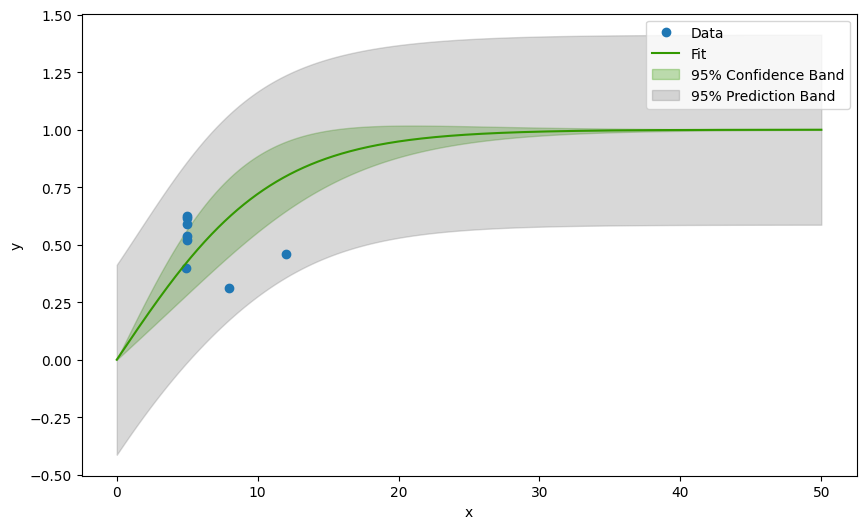

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(xs, ys, 'o', label='Data')
plt.plot(xfit, yfit, '-', label='Fit', color='#339900')
plt.fill_between(xfit, lower_conf, upper_conf, color='#339900', alpha=0.3, label='95% Confidence Band')
plt.fill_between(xfit, lower_pred, upper_pred, color='gray', alpha=0.3, label='95% Prediction Band')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Possible issues

- bands are not correct because duplicated rows lower the variance
- one would need to adjust the sigma and cov matrix (not sure if there is an easy way)

# Fitting a function with more than one parameter

In [54]:
# Example non-linear function
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Gradient function
def grad_func(x, a, b, c):
    grad_a = np.exp(-b * x)
    grad_b = -a * x * np.exp(-b * x)
    grad_c = np.ones_like(x)
    return np.array([grad_a, grad_b, grad_c]).T

In [55]:
# Generate synthetic data
np.random.seed(0)
x = np.linspace(0, 4, 50)
y = func(x, 2.5, 1.3, 0.5)
yn = y + 0.1 * np.random.normal(size=len(x))

# Fit the function to the data
popt, pcov = curve_fit(func, x, yn)

In [56]:
popt, pcov

(array([2.65360463, 1.27183237, 0.47300998]),
 array([[ 0.00400638,  0.00148607, -0.00023274],
        [ 0.00148607,  0.0044552 ,  0.00142501],
        [-0.00023274,  0.00142501,  0.00083026]]))

In [57]:
y_pred=func(x, *popt)
J = grad_func(x, *popt)  # Jacobian

In [58]:
pcov2 = np.sum((yn - y_pred)**2) / (len(yn) - len(popt)) * inv(np.dot(J.T, J))

In [59]:
pcov2

array([[ 0.00400649,  0.00148621, -0.00023271],
       [ 0.00148621,  0.00445543,  0.00142496],
       [-0.00023271,  0.00142496,  0.0008302 ]])

In [60]:
psigma=np.sqrt(np.sum((yn - y_pred)**2) / (len(x) - len(popt)))
psigma

0.10762376148889867

In [61]:
# Generate points for the fitted curve
xfit = np.linspace(0, 4, 1000)
yfit = func(xfit, *popt)

# Calculate lower and upper prediction and confidence bands
lower_pred, upper_pred = delta_pred_bounds(xfit, popt, pcov, psigma)
lower_conf, upper_conf = delta_conf_bounds(xfit, popt, pcov)

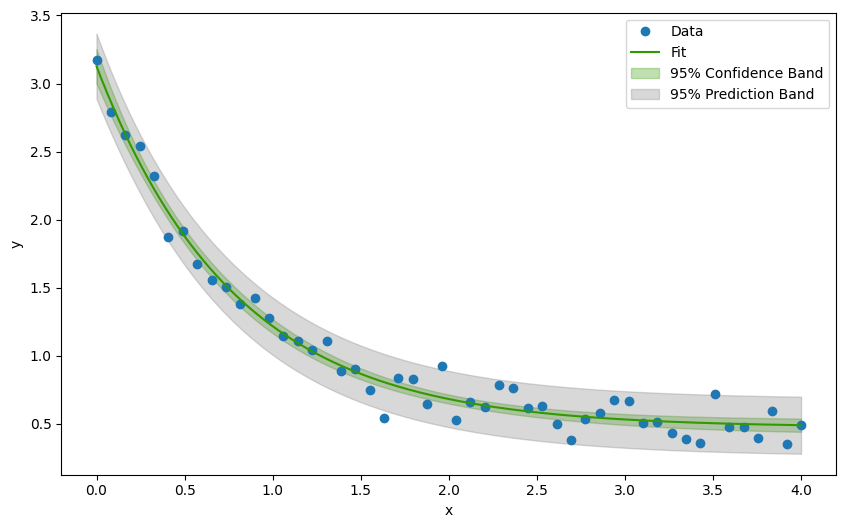

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(x, yn, 'o', label='Data')
plt.plot(xfit, yfit, '-', label='Fit', color='#339900')
plt.fill_between(xfit, lower_conf, upper_conf, color='#339900', alpha=0.3, label='95% Confidence Band')
plt.fill_between(xfit, lower_pred, upper_pred, color='gray', alpha=0.3, label='95% Prediction Band')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()